In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def generate_toy_data(n_samples, n_points):
    """
    Generates toy spatiotemporal data where points move in a simple
    sinusoidal or circular path with added noise.
    """
    x = torch.linspace(0, 2 * torch.pi, n_samples).unsqueeze(1)
    y = torch.sin(x).unsqueeze(-1).repeat(1, n_points, 2)  # Repeat sin(x) for each point
    # y += 0.1 * torch.randn(n_samples, n_points, 2)  # add noise
    next_y = torch.sin(x + 0.1).unsqueeze(-1).repeat(1, n_points, 2)  # Next frame's positions
    # next_y += 0.05 * torch.randn(n_samples, n_points, 2)  # add noise to next frame
    
    return y, next_y  # (current frame, next frame)

# MDN Model Definition
class MDN(nn.Module):
    def __init__(self, input_dim, n_points, n_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc_mu = nn.Linear(256, n_points * n_gaussians * 2)   # Means
        self.fc_sigma = nn.Linear(256, n_points * n_gaussians * 2) # Std deviations
        self.fc_pi = nn.Linear(256, n_points * n_gaussians)        # Mixture weights

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        mu = self.fc_mu(x).view(-1, n_points, n_gaussians, 2)
        sigma = F.softplus(self.fc_sigma(x)).view(-1, n_points, n_gaussians, 2) + 1e-6
        pi = torch.softmax(self.fc_pi(x).view(-1, n_points, n_gaussians), dim=-1)
        return mu, sigma, pi

# Loss function
def mdn_nll_loss(y, mu, sigma, pi):
    m = dist.Normal(mu, sigma)
    log_prob = m.log_prob(y.unsqueeze(2))  # Add Gaussian components dimension
    log_prob = torch.sum(log_prob, dim=-1) # Sum over x and y dimensions
    weighted_log_prob = log_prob + torch.log(pi)
    nll = -torch.logsumexp(weighted_log_prob, dim=-1)  # Log-sum-exp over gaussians
    return nll.mean()

# Sampling function
def sample_from_mdn(mu, sigma, pi, n_samples=1):
    batch_size, n_points, n_gaussians, _ = mu.shape
    samples = []
    
    for b in range(batch_size):
        point_samples = []
        for p in range(n_points):
            # Sample component
            categorical = dist.Categorical(pi[b, p])
            component = categorical.sample((n_samples,))
            
            # Sample from Gaussian
            chosen_mu = mu[b, p, component, :]
            chosen_sigma = sigma[b, p, component, :]
            normal_dist = dist.Normal(chosen_mu, chosen_sigma)
            
            # Sample n_samples from selected Gaussian component
            point_samples.append(normal_dist.sample())
        
        samples.append(torch.stack(point_samples).squeeze(1))
    
    return torch.stack(samples)  # Shape: (batch_size, n_points, n_samples, 2)

In [3]:
# Parameters
n_samples = 1000      # Number of frames
n_points = 5          # Points per frame (toy example for simplicity)
input_dim = n_points * 2  # Flattened x, y coordinates of all points
n_gaussians = 3       # Number of mixture components
output_dim = n_points * 2 * n_gaussians

# Generate the toy dataset
current_positions, next_positions = generate_toy_data(n_samples, n_points)
train_data = torch.flatten(current_positions, start_dim=1)  # Flatten for MLP input

In [4]:
# Training the model
model = MDN(input_dim=input_dim, n_points=n_points, n_gaussians=n_gaussians)
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    mu, sigma, pi = model(train_data)
    loss = mdn_nll_loss(next_positions, mu, sigma, pi)
    loss.backward()
    optimizer.step()
    if ((epoch % 1000)) == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 2.1943
Epoch 1000, Loss: -3.3188
Epoch 2000, Loss: -3.5864
Epoch 3000, Loss: -3.6696
Epoch 4000, Loss: -3.7327


In [5]:
# Generate samples for the next frame
N_SAMPLES = 50
with torch.no_grad():
    mu, sigma, pi = model(train_data[:10])  # First 10 frames as example
    samples = sample_from_mdn(mu, sigma, pi, n_samples=N_SAMPLES)

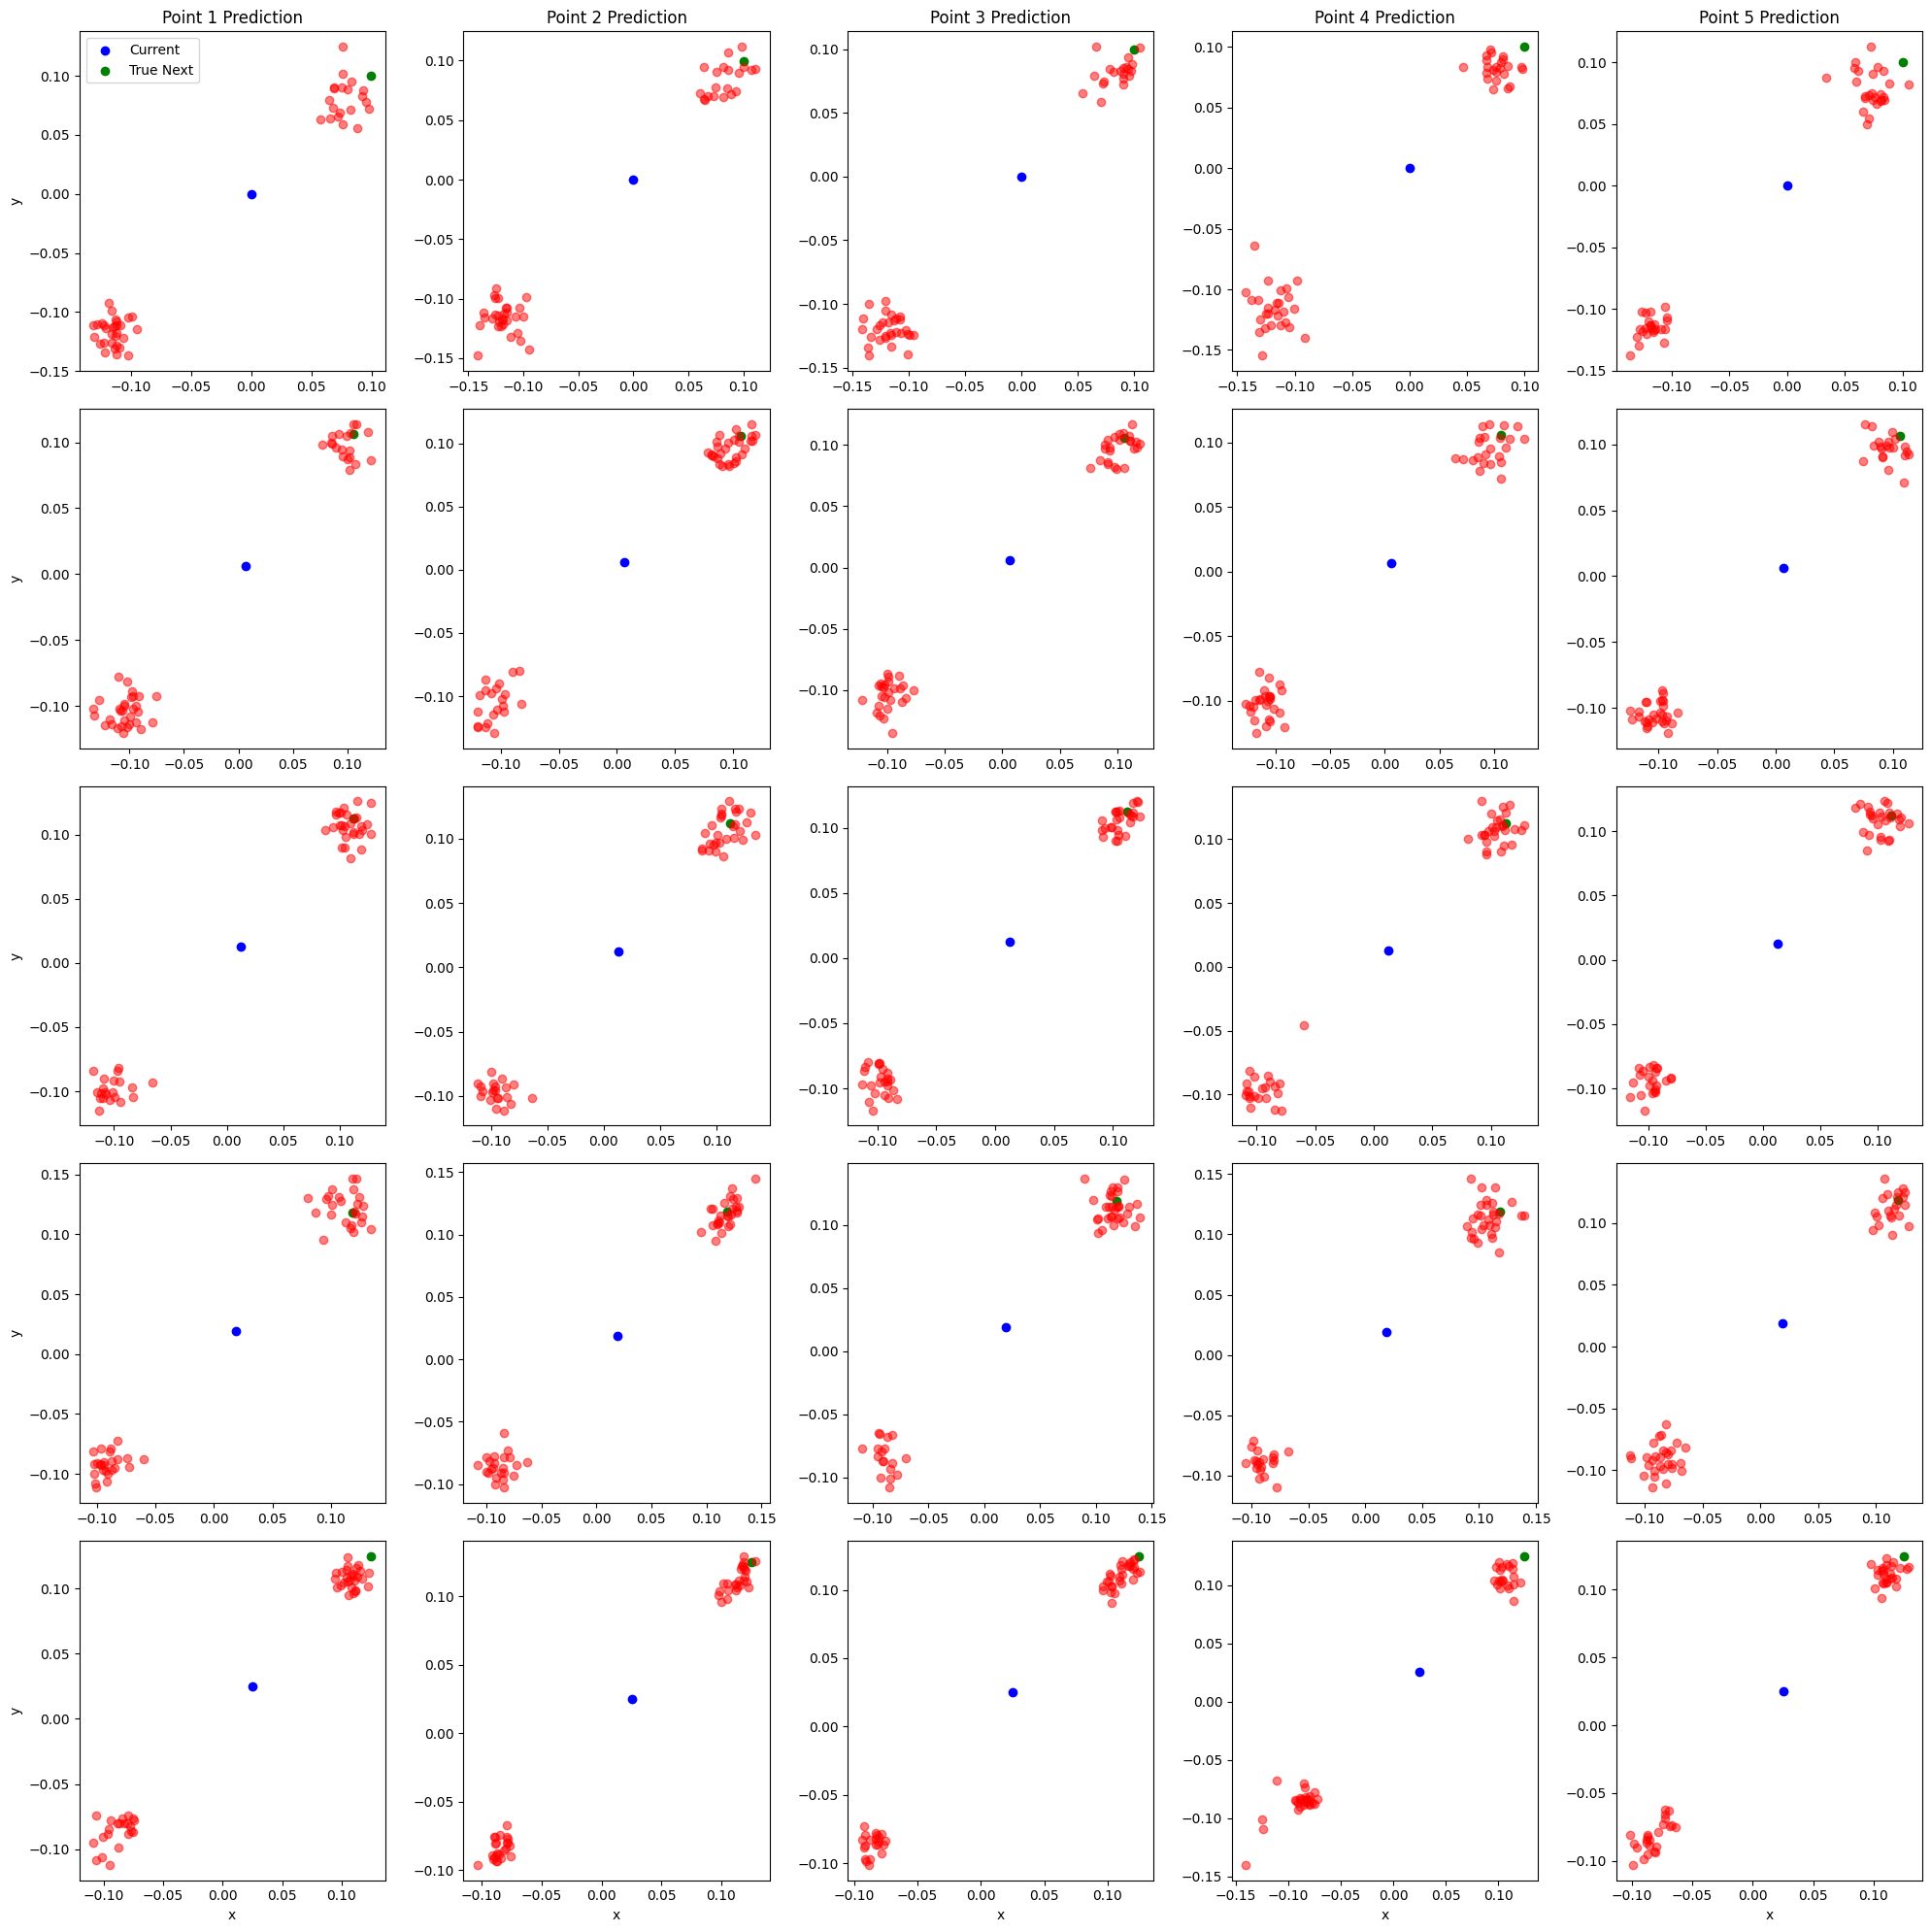

In [6]:
# Visualization of results
# Plot original points, true next positions, and sampled positions
plt.figure(figsize=(20, 20))
for j in range(n_points):
    for i in range(5):  # Plot for each point in the frame
        plt.subplot(n_points, 5, j*n_points + i + 1)
        plt.scatter(current_positions[j, i, 0], current_positions[j, i, 1], label='Current', color='blue')
        plt.scatter(next_positions[j, i, 0], next_positions[j, i, 1], label='True Next', color='green')
        for s in range(N_SAMPLES):
            plt.scatter(samples[j, i, s, 0], samples[j, i, s, 1], alpha=0.5, color='red')

        if j == n_points - 1:
            plt.xlabel("x")
        if i == 0:
            plt.ylabel("y")
        if j == 0:
            plt.title(f"Point {i+1} Prediction")
            if i == 0:
                plt.legend()

plt.tight_layout()
plt.show()